In [20]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/HNSD_mini/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

convert_ratio = {
    '0001': 0.001, 
    '001': 0.01, 
    '0005': 0.005, 
    '005': 0.05, 
    '01': 0.1
}
mode = "all"
all_cancer_classes = ["Liver", "Gastric", "Lung", "Breast", "CRC"]
# for input_cancer_class in all_cancer_classes:
for input_cancer_class in ["Liver"]:
    path_to_main_output = os.path.join(outdir, PROJECT, output_version)
    
    if mode == "all":
        path_to_09_output = os.path.join(outdir, PROJECT, output_version, "09_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        path_to_10_output = os.path.join(outdir, PROJECT, output_version, "10_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
    elif mode == "hypo_only":
        path_to_09_output = os.path.join(outdir, PROJECT, output_version, "09_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        path_to_10_output = os.path.join(outdir, PROJECT, output_version, "10_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
    elif mode == "hyper_only":
        path_to_09_output = os.path.join(outdir, PROJECT, output_version, "09_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        path_to_10_output = os.path.join(outdir, PROJECT, output_version, "10_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))

    os.system(f"mkdir -p {path_to_10_output}")

    all_files = [item for item in pathlib.Path(path_to_09_output).glob("*.candi_reads.csv")]
    countdf = pd.read_csv(os.path.join(path_to_09_output, "all_count.csv"), index_col = [0])

    all_samples = []
    all_mean_candi_reads = []
    for file in all_files:
        tmpdf = pd.read_csv(file)
        mean_candi_reads = tmpdf.candi_reads.mean()
        all_samples.append(file.name.split(".")[0])
        all_mean_candi_reads.append(mean_candi_reads)

    candidf = pd.DataFrame({"SampleID": all_samples, "num_candi_reads": all_mean_candi_reads})
    candidf = candidf.merge(countdf, right_on = "SampleID", left_on = "SampleID")
    candidf["ratio_raw"] = candidf["num_candi_reads"] / candidf["raw_count"]
    candidf["ratio_in_reads"] = candidf["num_candi_reads"] / candidf["in_read_count"]
    candidf.to_excel(os.path.join(path_to_10_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)), index = False)

    candidf = candidf.fillna(0)
    candidf["Background"] = candidf["SampleID"].apply(lambda x: x.split("_")[0])
    candidf["spike_in_ratio"] = candidf["SampleID"].apply(lambda x: convert_ratio[x.split("__")[1].split("_")[0]])
    candidf["log_spike_in_ratio"] = candidf["SampleID"].apply(lambda x: np.log(convert_ratio[x.split("__")[1].split("_")[0]]))
    candidf["tumor_spikein"] = candidf["SampleID"].apply(lambda x: x.split("from_")[1].split("_")[0])
    candidf["replicate"] = candidf["SampleID"].apply(lambda x: x.split("_")[-1])




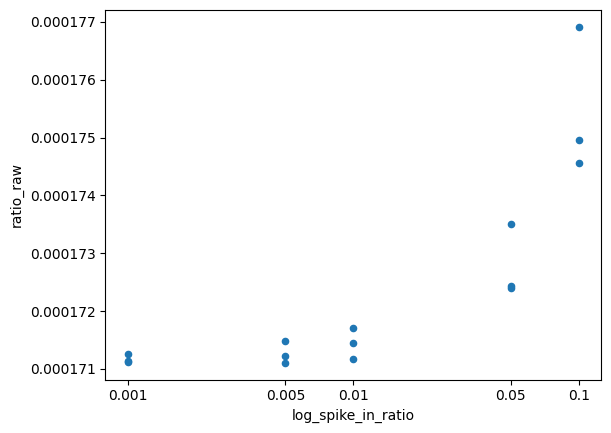

In [25]:
candidf[candidf["Background"] == "K0006"].plot(x = "log_spike_in_ratio", y = "ratio_raw", kind = "scatter")
xticks_labels = [convert_ratio[key] for key in convert_ratio.keys()]
plt.xticks(ticks=np.log(list(convert_ratio.values())), labels=xticks_labels)
plt.title(title_raw)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(path_to_08_output, figname1), format='svg')
plt.show()